In [ ]:
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("hf://datasets/scikit-learn/adult-census-income/adult.csv")

df = df[['age', 'workclass', 'education', 'education.num', 'marital.status',
         'occupation', 'relationship', 'race', 'sex', 'capital.gain',
         'capital.loss', 'hours.per.week', 'native.country', 'income']]

df = pd.get_dummies(df, columns=['workclass', 'education', 'marital.status',
                                 'occupation', 'relationship', 'race', 'native.country', 'sex'], drop_first=True)

df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

y = df['income']
X = df.drop(columns=['income'])

group = df['sex_Male']

In [2]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    X, y, group, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
def build_mlp(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_mlp(X_train.shape[1])
print("Model training...")
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))
print("Model training completed!")

Model training...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8039 - loss: 0.4159 - val_accuracy: 0.8477 - val_loss: 0.3319
Epoch 2/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8502 - loss: 0.3248 - val_accuracy: 0.8446 - val_loss: 0.3236
Epoch 3/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8530 - loss: 0.3199 - val_accuracy: 0.8497 - val_loss: 0.3206
Epoch 4/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8546 - loss: 0.3147 - val_accuracy: 0.8492 - val_loss: 0.3188
Epoch 5/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8593 - loss: 0.3061 - val_accuracy: 0.8509 - val_loss: 0.3171
Epoch 6/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8587 - loss: 0.3065 - val_accuracy: 0.8512 - val_loss: 0.3213
Epoch 7/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8582 - loss: 0.3097 - val_accuracy: 0.8486 - val_loss: 0.3192
Epoch 8/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8615 - loss: 0.2975 - val_accuracy: 0.8468 - val_

In [ ]:
def predict_fn(X_numpy):
    return model(X_numpy, training=False).numpy().flatten()

explainer = shap.KernelExplainer(predict_fn, X_train_scaled[:50])
shap_values = explainer.shap_values(X_test_scaled[:100], nsamples=50)

shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=X.columns)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
df_importance = pd.DataFrame({'Features': X.columns, 'Mean SHAP Value': mean_abs_shap})
df_importance = df_importance.sort_values('Mean SHAP Value', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='Features', x='Mean SHAP Value', data=df_importance.head(20), color='steelblue')
plt.title("Top 20 Features by SHAP Values")
plt.xlabel("Mean SHAP Value")
plt.tight_layout()
plt.show()

print("\nSHAP Table (Top Features):")
display(df_importance.head(20))

In [5]:
attack_model = build_mlp(X_train.shape[1])
attack_model.set_weights(model.get_weights())
optimizer = optimizers.Adam(learning_rate=0.001)

def fool_shap(model, sample_X, sample_group, epochs=50):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            preds = model(sample_X, training=True)
            preds = tf.squeeze(preds)

            male_preds = tf.boolean_mask(preds, sample_group == 1)
            female_preds = tf.boolean_mask(preds, sample_group == 0)

            male_mean = tf.reduce_mean(male_preds)
            female_mean = tf.reduce_mean(female_preds)

            loss = tf.abs(male_mean - female_mean)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Fooling Loss = {loss.numpy():.4f}")

print("\nNormal SHAP fooling starting...")
fool_shap(attack_model, X_test_scaled[:100], group_test[:100], epochs=50)
print("Fooling completed!")


Normal SHAP fooling starting...
Epoch 0: Fooling Loss = 0.2049


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 5: Fooling Loss = 0.1830
Epoch 10: Fooling Loss = 0.1367
Epoch 15: Fooling Loss = 0.1043
Epoch 20: Fooling Loss = 0.0730
Epoch 25: Fooling Loss = 0.0590
Epoch 30: Fooling Loss = 0.0144
Epoch 35: Fooling Loss = 0.0049
Epoch 40: Fooling Loss = 0.0080
Epoch 45: Fooling Loss = 0.0121
Fooling completed!


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.955e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.746e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.795e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 6

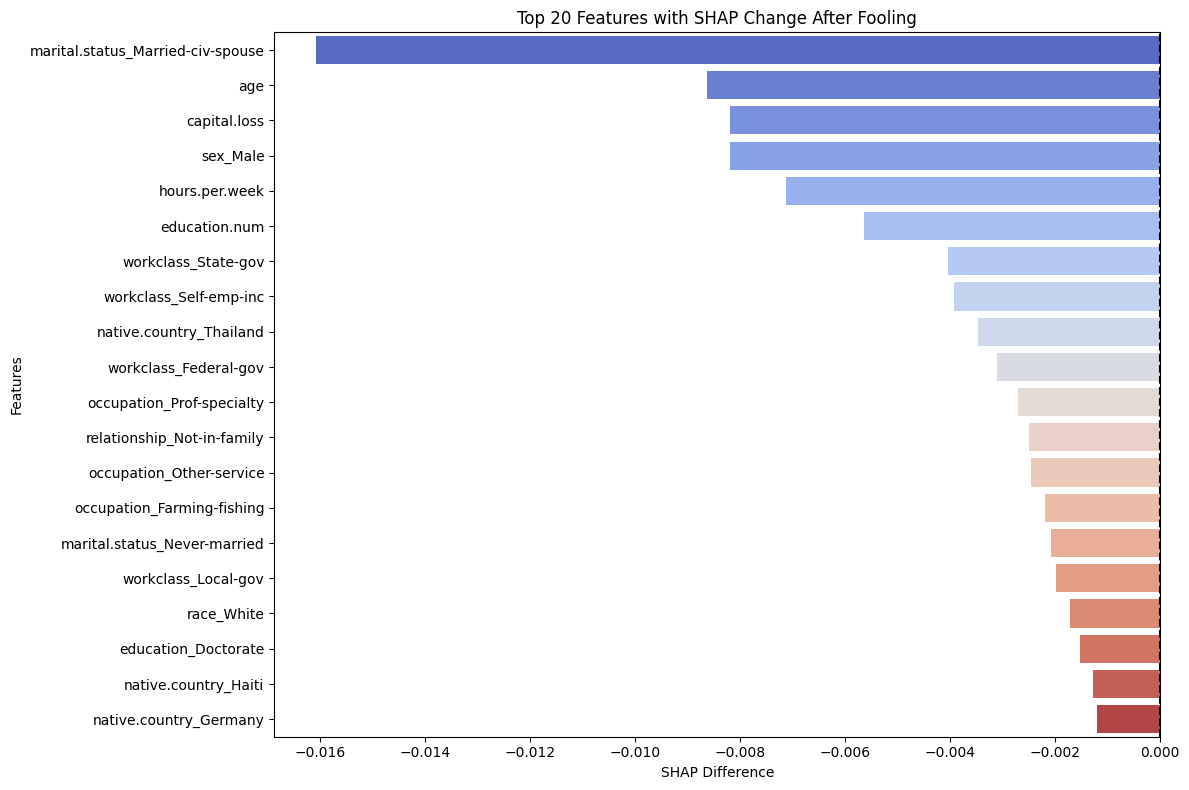

SHAP average change after fooling: -0.000600
SHAP percent change after fooling: %-18.61


In [6]:
explainer_fool = shap.KernelExplainer(lambda x: attack_model(x, training=False).numpy().flatten(), X_train_scaled[:50])
shap_values_fool = explainer_fool.shap_values(X_test_scaled[:100], nsamples=50)

mean_shap_fool = np.abs(shap_values_fool).mean(axis=0)
df_importance_fool = pd.DataFrame({'Features': X.columns, 'Mean SHAP Value (Fool)': mean_shap_fool})
df_importance_fool = df_importance_fool.sort_values('Mean SHAP Value (Fool)', ascending=False)

comparison = pd.merge(df_importance, df_importance_fool, on="Features", how="inner")
comparison["SHAP Difference"] = comparison["Mean SHAP Value (Fool)"] - comparison["Mean SHAP Value"]
comparison = comparison.sort_values("SHAP Difference")

plt.figure(figsize=(12, 8))
sns.barplot(x="SHAP Difference", y="Features", data=comparison.head(20), palette="coolwarm")
plt.axvline(0, color='black', linestyle='--')
plt.title("Top 20 Features with SHAP Change After Fooling")
plt.tight_layout()
plt.show()

mean_shap_before = df_importance["Mean SHAP Value"].mean()
mean_shap_after = df_importance_fool["Mean SHAP Value (Fool)"].mean()
diff = mean_shap_after - mean_shap_before
percent_change = (diff / abs(mean_shap_before)) * 100

print(f"SHAP average change after fooling: {diff:.6f}")
print(f"SHAP percent change after fooling: %{percent_change:.2f}")